# Introduction

This cell downloads the data as needed when not on Kaggle.

In [ ]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [ ]:
# !~/anaconda3/bin/ipython kernel install --user --name anaconda

We'll be using numpy and pytorch for array calculations in this notebook, and pandas for working with tabular data, so we'll import them and set them to display using a bit more space than they default to.

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

/Users/swylie/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cleaning the data

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# the number of nans in each column
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# the mode value of each column 
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
#use fillna to replace the missing values with the mode of each column 
#doing it "in place" -- meaning that we'll change the dataframe itself, 
#rather than returning a new one
df.fillna(modes, inplace=True)

# check that the nans are now removed
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [8]:
# quick summary of all the numeric columns in the datase
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


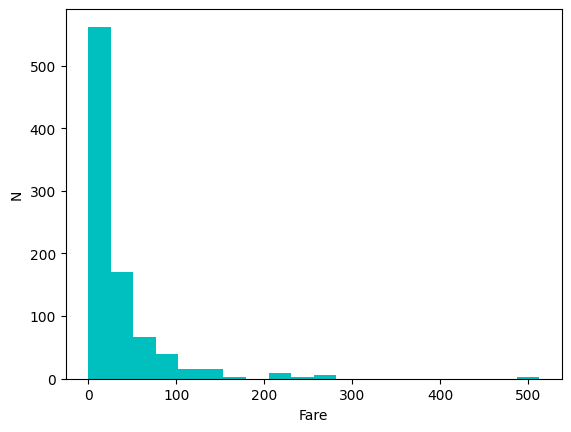

In [9]:
# histogram of the fares paid by the passengers - notice the long tail
plt.hist(df['Fare'], bins = 20, color = 'c')
plt.xlabel('Fare')
plt.ylabel('N')
plt.show()

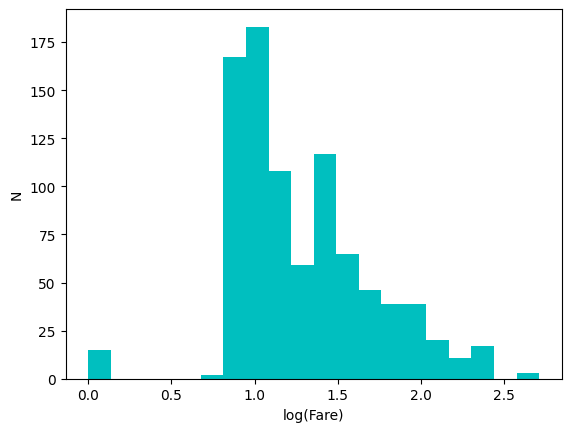

In [10]:
# take logrithm of Fare values to "squish" it so that the outliars don't dominate future calculations
df['LogFare'] = np.log10(df['Fare']+1) # add 1 becuase Fare contains zeros

# plot histogram of logged values
plt.hist(df['LogFare'], bins = 20, color = 'c')
plt.xlabel('log(Fare)')
plt.ylabel('N')
plt.show()

In [11]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [12]:
# quick summary of all the non-numeric columns columns in the datase
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [13]:
# create new columns containing dummy variables for string columns with reasonable # of unique values
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [14]:
from torch import tensor

# set the dependent variable, Survived, as a tensor
t_dep = tensor(df.Survived)

# set the independent continous variables as tensors
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype = torch.float)

# the number of rows and columns we have for our independent variables
t_indep.shape

torch.Size([891, 12])

# Setting up a linear model


In [15]:
# set random seed
torch.manual_seed(442)

# first model will be a simple linear model
# we need an initial coefficient for each column in t_indep
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5  # center random numbers arround 0 [-0.5, 0.5]
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [16]:
# the predictions will be calculated by multiplying each row by the coefficients, and adding them up
# first make all the columns contain numbers from 0 to 1, by dividing each column by its max()
# so that the sums of each row won't be dominated by a column which intrinsically just has larger numbers (scale)
vals, indices = t_indep.max(dim=0)
t_indep = t_indep/vals

In [17]:
# create predictions from our linear model, by adding up the rows of the product
preds = (t_indep*coeffs).sum(axis=1)
preds[:10] # currently means nothing as coefficients used are random - need loss function + gradient descent

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [18]:
# calcualte the loss
loss = torch.abs(preds-t_dep).mean() #average error of the rows
loss

tensor(0.5382)

In [19]:
# create functions to do the jobs for us
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

# gradient descent step

In [20]:
# to get PyTorch to calculate gradients, we'll need to call requires_grad_() on our coeffs
coeffs.requires_grad_()

# now when we calculate our loss, PyTorch will keep track of all the steps, 
# so we'll be able to get the gradients afterwards
loss = calc_loss(coeffs, t_indep, t_dep)

# use backward() to ask PyTorch to calculate gradients now
loss.backward()
coeffs.grad # each time we call backward, the gradients are actually added to whatever is in the .grad attribute

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [21]:
# # rerun
# loss = calc_loss(coeffs, t_indep, t_dep)
# loss.backward()
# coeffs.grad 
# # our .grad values are have doubled because it added the gradients a second time
# # For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero

In [22]:
# loss = calc_loss(coeffs, t_indep, t_dep)
# loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad*0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5197)


# Training a linear model

In [23]:
# use RandomSplitter to get indices that will split our data into training and validation sets
from fastai.data.transforms import RandomSplitter

trn_split, val_split=RandomSplitter(seed=42)(df)

In [24]:
# apply those indicies to our independent and dependent variables
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

In [25]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()
    
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")
        
def init_coeffs():
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [26]:
def train_model(epochs=30, lr = 0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr) 
    return coeffs
    

In [27]:
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

In [28]:
def show_coeffs(): 
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

# Accuracy 

In [29]:
preds = calc_preds(coeffs, val_indep)

In [35]:
results = val_dep.bool() == (preds>0.5) #  assume that a score of over 0.5 == survived
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [37]:
results.float().mean()

tensor(0.7865)

In [39]:
# function to return accuracy 
def acc(coeffs):
    return (val_dep.bool() == (calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

# Using a sigmoid

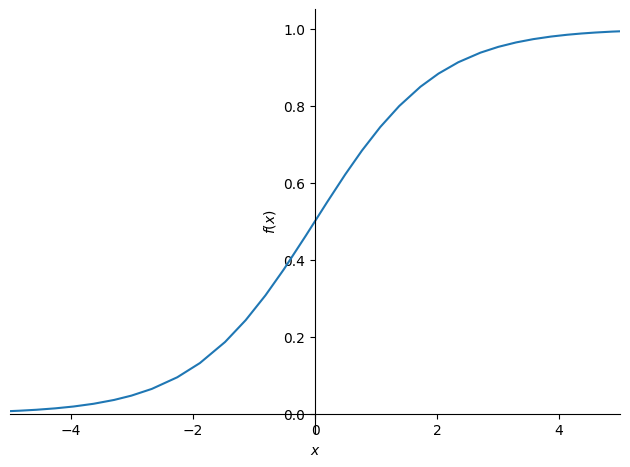

In [49]:
# There is a problem, some predictions are >1 and some are <0 
# Solution pass all predictions through a sigmoid function which has a min and max of 0 and 1 respectively
import sympy 
sympy.plot("1/(1+exp(-x))", xlim=(-5,5))

In [55]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))
coeffs = train_model(lr = 100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [56]:
acc(coeffs)

tensor(0.8258)

In [57]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

# Submitting to Kaggle

In [62]:
tst_df = pd.read_csv(path/'test.csv')

In [63]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [64]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [65]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [66]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)


In [67]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


In [68]:
# Python uses the @ operator to indicate matrix products
val_indep@coeffs # = (val_indep*coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8722,
        -21.7230,  13.3603, -15.56

In [69]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)
        
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()


In [70]:
trn_dep = trn_dep[:, None]
val_dep = val_dep[:, None]

In [74]:
coeffs = train_model(lr=2)

0.512; 0.470; 0.429; 0.397; 0.374; 0.356; 0.343; 0.332; 0.323; 0.315; 0.308; 0.302; 0.296; 0.291; 0.286; 0.282; 0.278; 0.275; 0.271; 0.269; 0.266; 0.263; 0.261; 0.259; 0.257; 0.255; 0.254; 0.252; 0.251; 0.249; 

In [75]:
acc(coeffs)

tensor(0.8034)

In [76]:
coeffs

tensor([[-0.2730],
        [-0.0415],
        [ 0.0806],
        [ 0.1472],
        [-2.2458],
        [ 1.8436],
        [ 0.7121],
        [ 0.3170],
        [-1.2154],
        [ 0.2212],
        [ 0.0933],
        [-0.5955]], requires_grad=True)

In [77]:
coeffs.shape

torch.Size([12, 1])

# Neutral network

In [111]:
import torch.nn.functional as F
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    for layer in coeffs: layer.sub_(layer.grad * lr )

In [112]:
coeffs = train_model(lr=1.4)

0.543; 0.532; 0.509; 0.467; 0.396; 0.315; 0.271; 0.239; 0.213; 0.206; 0.208; 0.210; 0.211; 0.209; 0.203; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.193; 0.194; 0.193; 0.191; 0.191; 0.192; 0.192; 0.192; 0.192; 

In [113]:
acc(coeffs)

tensor(0.8258)

In [116]:
[n_coeff]

[12]

In [119]:
hiddens = [10,10]

In [123]:
[n_coeff] + hiddens + [1]

[12, 10, 10, 1]